### Modelos Pré Treinados

Podemos também utilizar CNNs por meio de modelos pré-treinados, isto é, modelos que já foram treinados previamente em uma outra base de dados e que podem ser aplicados em outro problema.

* As arquiteturas populares de CNNs comumente são utilizadas nesse contexto
* Keras.applications possui os [modelos pré-treinados](https://keras.io/api/applications/) dessas arquiteturas

Muitas vezes podemos aproveitar esse modelo pré-treinado para nossas aplicações fazendo pequenos ajustes ([fine-tuning](https://keras.io/guides/transfer_learning/)), chamamos essa abordagem de **transfer learning**.

* Que ajustes são esses?
  * Adicionar mais camadas após a arquitetura pré-treinada
  * Aproveitar o treinamendo apenas de algumas camadas da rede pré-treinada  

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

### Leitura do dataset

Podemos usar o ImageDataGenerator para leitura do dataset por batches. Esse recurso é bastante utilizado quando temos um dataset grande para evitar problemas de memória RAM

Para isso, podemos ter um dataset tal que cada classe esteja organizada em pastas, conforme figura abaixo. Note que cada partição tem um diretório (treino, teste e val), bem como suas classes.

<img src=https://miro.medium.com/max/1400/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg>

Caso não seja possível organizarmos o dataset dessa forma, podemos utilizar uma função bem semelhante chamada [flow_from_dataframe](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), em que criamos um csv com o path das nossas imagens e colocamos o tensorflow para realizar a leitura das imagens a partir deste dataframe

In [1]:
import tensorflow as tf

train_datagen = image.ImageDataGenerator(rescale=1/255)  ## define o generator escalando as imagens do dataset
val_datagen = image.ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory( ### pega as imagens de um dataset
        'dataset/seg_train',
        target_size=(128, 128),
        batch_size=64,
        class_mode='categorical',
        shuffle = True)

val_dataset = val_datagen.flow_from_directory(
        'dataset/seg_test',
        target_size=(128, 128),
        batch_size=64,
        class_mode='categorical',
        shuffle = True)

NameError: name 'image' is not defined

3


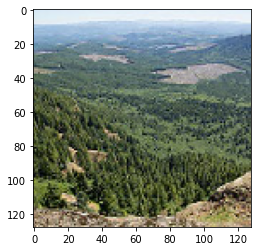

4


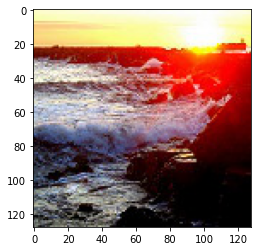

5


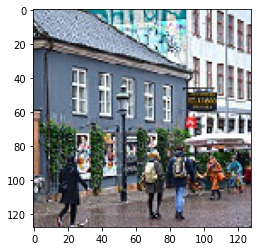

4


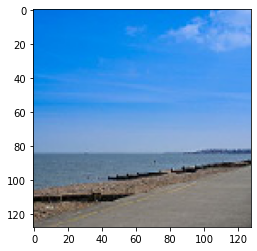

3


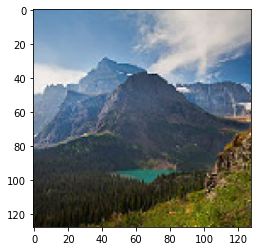

In [3]:
# Imprimir imagens - pode usar o opencv
import matplotlib.pyplot as plt
import numpy as np

for _ in range(5):
    img, label = train_dataset.next()
    print(np.argmax(label[0]))
    plt.imshow(img[0])
    plt.show()

### Importar arquitetura de rede

In [4]:
from tensorflow import keras

In [22]:
base_model = keras.applications.ResNet50( #### escolha de uma arquitetura do keras.applications
    weights='imagenet', ### utiliza os pesos da imagenet 
    input_shape=(150, 150, 3),
    include_top=False)  ### exclui a camada softmax do 'imagenet' que tem 1000 classes

In [23]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Treinando uma arquitetura de rede

Uma vez importada a arquitetura, podemos criar um modelo propriamente dito definindo nossas inputs e outputs. Note que o nosso modelo **não é sequencial**, então ao invés de criarmos o modelo pelo model.add, criamos uma variável X e vamos incrementando a cada função

Essa é uma estrutura simples para utilizarmos a mesma arquitetura sem modificações, caso quisessemos adicionar mais camadas, bastava adicionar outras Dense por exemplo após o GlobalAveragePooling

In [24]:
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(6)(x)
model = keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 23,546,886
Non-trainable params: 53,120
_________________________________________________________________


In [26]:
from tensorflow.python.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta = 0.001, patience = 8)
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_dataset, epochs=20, batch_size=128, validation_data=val_dataset, callbacks=[es])

Epoch 1/20
 13/220 [>.............................] - ETA: 11:46 - loss: 8.0524 - accuracy: 0.1791

KeyboardInterrupt: 

### Modelo pré-treinado

A forma anterior realiza o treinamento do zero, apenas importando o modelo. Podemos notar isso observando o summary do modelo. Temos um total de parâmetros treinaveis bem superior ao total de parâmetros não treináveis.

Caso queiramos congelar as camadas e não realizar treinamento algum, aproveitando o treinamento do modelo com a ImageNet, definimos o trainable=False

Ao fazermos isso, congelaremos todas as camadas da Xception.

OBS; lembrando qeu também podemos congelar parcialmente as camadas, sendo uma prática comum congelarmos apenas as camadas iniciais. A [documentação do keras](https://keras.io/guides/transfer_learning/) mostra esse caso.  Resumidamente, selecionamos quais camadas queremos manter e colocamos o trainable=False da mesma forma

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet', 
    input_shape=(150, 150, 3),
    include_top=False)  

In [17]:
base_model.trainable=False
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x1 = keras.layers.Dense(100, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
outputs2 = keras.layers.Dense(40, activation='softmax')(x)
model = keras.Model(inputs, [outputs, outputs2])

Perceba que agora o summary contém bem mais parâmetros não treináveis do que treinaveis

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta = 0.001, patience = 8)
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[es])

Epoch 1/20
220/220 [==============================] - 262s 1s/step - loss: 8.2543 - accuracy: 0.1620 - val_loss: 8.3384 - val_accuracy: 0.1700
Epoch 2/20
220/220 [==============================] - 394s 2s/step - loss: 8.2543 - accuracy: 0.1620 - val_loss: 8.3384 - val_accuracy: 0.1700
Epoch 3/20
220/220 [==============================] - 521s 2s/step - loss: 8.2543 - accuracy: 0.1620 - val_loss: 8.3384 - val_accuracy: 0.1700
Epoch 4/20
220/220 [==============================] - 563s 3s/step - loss: 8.2543 - accuracy: 0.1620 - val_loss: 8.3384 - val_accuracy: 0.1700
Epoch 5/20
220/220 [==============================] - ETA: 0s - loss: 8.2543 - accuracy: 0.1620 

### Fluxo de Redes Neurais

Em geral, podemos dizer que temos diferentes possibilidades de uso de redes neurais dependendo da aplicação

A decisão de que tipo de rede usar inicia analisando o tamanho e complexidade do dataset


![Title](imgs/fluxo.png)
